# Clase 22: Selección de Características e Hiperparámetros

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

**Profesor: Pablo Badilla**

## Objetivos de esta clase

- Comprender la importancia de seleccionar características y reducir dimensionalidad.
- Selección de Atributos/Características.
- Reducción de dimensionalidad.
- Integrar estas técnicas con `Pipeline`
- Buscar la mejor configuración de hiperparámetros con `GridSearch`

In [31]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

df = pd.read_csv("./resources/descriptores_musica.csv")
df = df.astype({"time_signature": str, "key": str, "mode": str})

### Proyección de las Features Numéricas

---

## Problema de Hoy: 🎸🤘 Caracterización Musical 🎼🎵 

<div align='center'>
<img src='./resources/spotify.png' width=200/>
</div>

 
    
Los atributos son: 

- `key`: escala de la canción. 0 = C, 1 = C♯/D♭, 2 = D...  [Mas información](https://en.wikipedia.org/wiki/Pitch_class).
- `modo`: 1 si la escala es mayor, 0 si es menor.
- `time_signature`: cuántos pulsos hay en cada compás. (4, 3,...).
- `loudness`: Volumen de la canción (rango -60, 0).


- `acousticness`: Probabilidad de que la canción sea solo acústica.
- `danceability`: Describe que tan bailable es la canción. (rango 0, 1).
- `energy`: Mide que tan energética es una canción (rango 0, 1).
- `instrumentalness`: Probabilidad que la canción contenga voces.
- `liveness`: Probabilidad de que la canción fuese grabada en vivo.
- `speechiness`: Probabilidad de que la canción sea exclusivamente vocal (ejemplo: podcast : 1). 
- `valence`: Sentimiento de la canción (rango 0, 1). 1 -> felicidad, alegria, euforia. 0 -> Tristeza, enojo, depresión.
- `tempo` : Pulsos por minuto de la canción (BPM). 


La variable a predecir es: 

- `genre`: Género de la canción.


**Pregunta**: A simple vista,

- ¿Hay carácterísticas que podrían estas repetidas? (**Irrelevante**)
- ¿hay características que nos dicen mas o menos lo mismo? (**Redundante**)


### Análisis Exploratorio de Datos

In [32]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("./resources/descriptores_musica.csv")
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre
0,0.617,0.771,10,-5.586,0,0.1120,0.0384,0.000003,0.1620,0.553,180.002,3nCFiwtuVqVJmnSasApvr3,267747,4,Salgo Pa' la Calle,Daddy Yankee,Reggaeton
1,0.788,0.674,2,-8.392,1,0.0537,0.2810,0.033000,0.0892,0.864,94.997,5I0u5YHYvA6fQZstVCFwqC,214747,4,Dile A Tu Amiga,Ñejo,Reggaeton
2,0.745,0.744,5,-8.230,1,0.0837,0.0266,0.000018,0.0959,0.849,96.026,1FTTvjvgX2Qd9ZJqo36m1C,244663,4,Nada Va Pasar,Yaga Y Mackie,Reggaeton
3,0.782,0.767,9,-7.981,0,0.0871,0.2660,0.000036,0.0947,0.622,88.005,6DxS2ZRl8G3EagHkovYXA2,304091,4,Zun Da Da,Zion,Reggaeton
4,0.702,0.864,1,-5.496,1,0.0818,0.1080,0.000000,0.1870,0.788,94.994,4mM90OUhSN79RRKT0qv4dY,215118,4,Fuera del Planeta,Randy,Reggaeton


In [33]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,8.140000e+02,814.000000
mean,0.600392,0.589244,5.491400,-10.017713,0.598280,0.090809,0.324999,0.159151,0.181294,0.532020,113.486484,2.838903e+05,3.926290
std,0.196368,0.268840,3.694922,6.429775,0.490547,0.095219,0.342813,0.304559,0.151797,0.268382,26.527836,1.284673e+05,0.356933
min,0.062300,0.002100,0.000000,-42.238000,0.000000,0.023200,0.000017,0.000000,0.031100,0.030800,59.406000,8.426700e+04,1.000000
25%,0.479250,0.417500,2.000000,-11.555500,0.000000,0.036500,0.033450,0.000000,0.090675,0.324000,94.013500,2.112300e+05,4.000000
50%,0.641500,0.663500,6.000000,-7.997500,1.000000,0.047550,0.180000,0.000405,0.122000,0.569000,110.033500,2.512800e+05,4.000000
75%,0.753000,0.799000,9.000000,-5.854750,1.000000,0.098000,0.575250,0.095600,0.226750,0.754000,126.928250,3.087402e+05,4.000000
max,0.976000,0.989000,11.000000,-1.446000,1.000000,0.817000,0.996000,0.958000,0.987000,0.981000,213.990000,1.252322e+06,5.000000


In [34]:
def get_ejemplo(idx):
    """
    Obtiene un ejemplo y lo formatea como columna.
    """
    ejemplo = (
        df.loc[
            idx,
            [
                "danceability",
                "energy",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "valence",
                "name",
                "artist",
                "genre",
            ],
        ]
        .to_frame()
        .reset_index()
    )
    ejemplo.columns = ["Descriptor", "Valor"]
    return ejemplo

In [35]:
# pueden cambiar el índice de alguno de estos ejemplos para
# mostrar otra canción en la visualización
ejemplo1 = get_ejemplo(102)
ejemplo2 = get_ejemplo(385)
ejemplo3 = get_ejemplo(15)
ejemplo4 = get_ejemplo(484)

ejemplos = [ejemplo1, ejemplo2, ejemplo3, ejemplo4]

#### Spider/Radar Chart

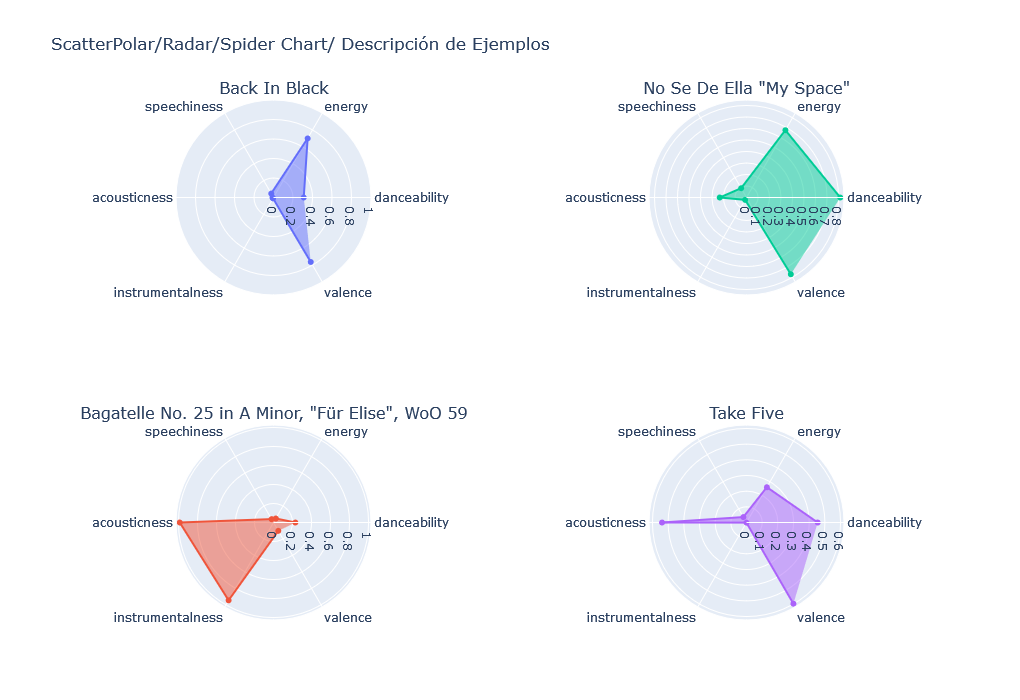

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[
        [{"type": "polar"}, {"type": "polar"}],
        [{"type": "polar"}, {"type": "polar"}],
    ],
    subplot_titles=[
        ejemplo1.loc[6, "Valor"],
        ejemplo3.loc[6, "Valor"],
        ejemplo2.loc[6, "Valor"],
        ejemplo4.loc[6, "Valor"],
    ],
)

for i, ejemplo in enumerate(ejemplos):
    fig.add_trace(
        go.Scatterpolar(
            r=ejemplo.loc[0:5, "Valor"],
            theta=ejemplo.loc[0:5, "Descriptor"],
            fill="toself",
            name=f"{ejemplo.loc[6, 'Valor']} - {ejemplo.loc[7, 'Valor']} ({ejemplo.loc[8, 'Valor']})",
        ),
        col=i // 2 + 1,
        row=i % 2 + 1,
    )

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=False,
    title="ScatterPolar/Radar/Spider Chart/ Descripción de Ejemplos",
    height=700,
)

fig.show()

#### Correlaciones

In [37]:
corr = df.loc[
    :,
    [
        "danceability",
        "energy",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "valence",
        "name",
        "artist",
        "genre",
    ],
].corr()

#### Histogramas

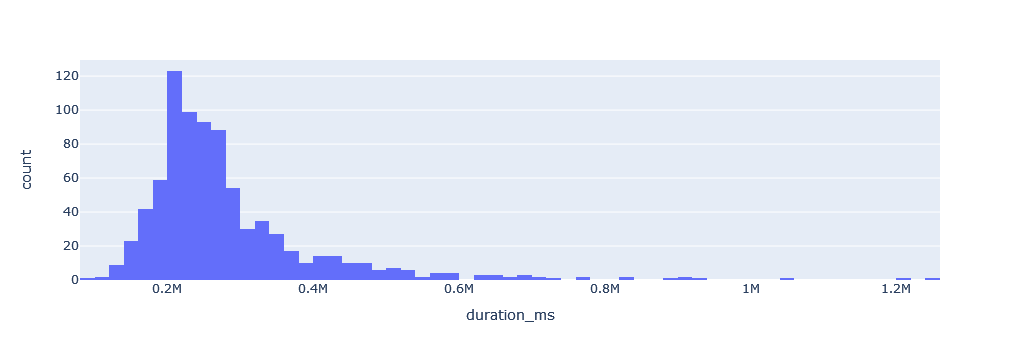

In [38]:
px.histogram(df, x="duration_ms")

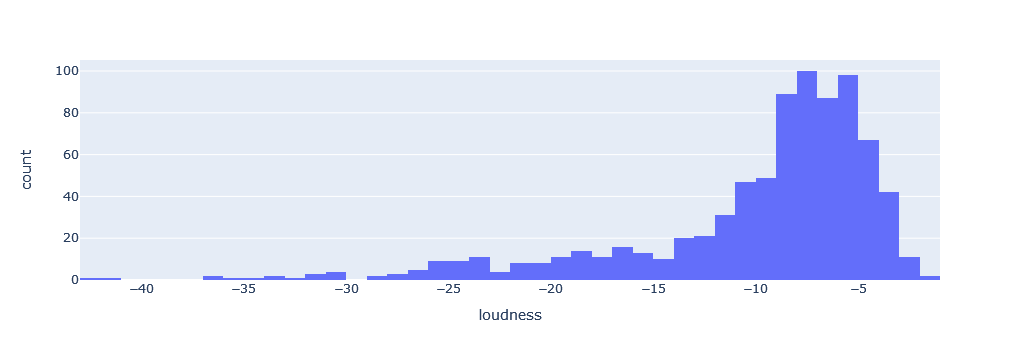

In [39]:
px.histogram(df, x="loudness")

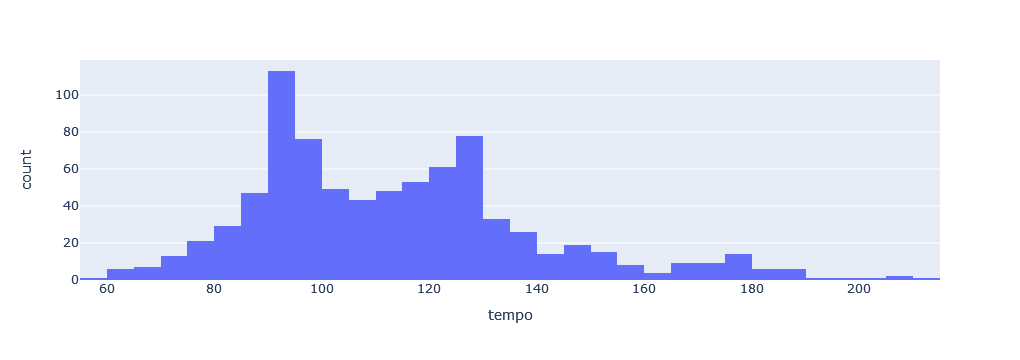

In [40]:
px.histogram(df, x="tempo")

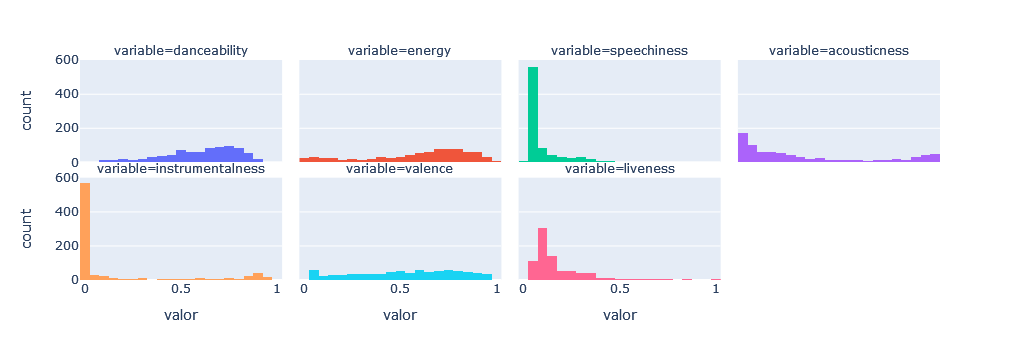

In [41]:
dt_to_hists = df.loc[
    :,
    [
        "danceability",
        "energy",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "valence",
        "liveness",
        "genre",
    ],
].melt(id_vars=["genre"], var_name="variable", value_name="valor")

px.histogram(
    dt_to_hists, x="valor", color="variable", facet_col="variable", facet_col_wrap=4
).update_layout(showlegend=False)

### Correlaciones

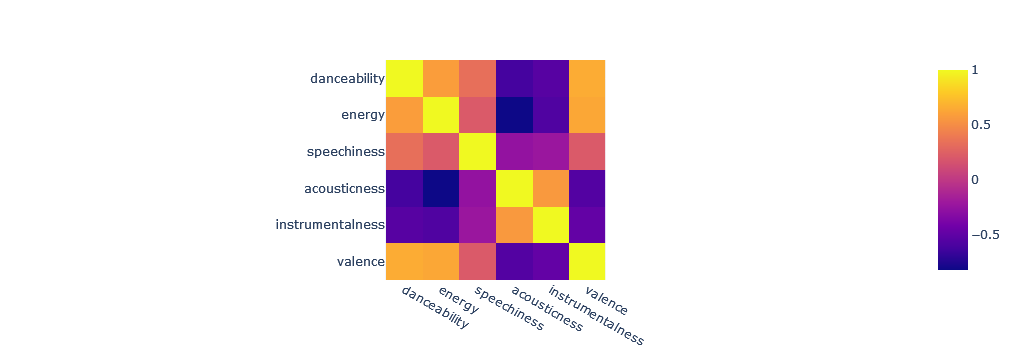

In [42]:
px.imshow(corr)

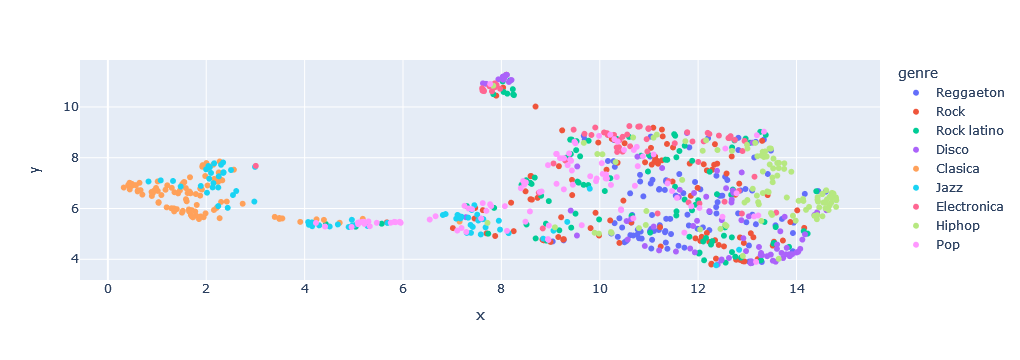

In [43]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from umap import UMAP

projection_pipe = Pipeline(
    [
        (
            "Column Transformer",
            ColumnTransformer(
                [("MinMax", MinMaxScaler(), ["duration_ms", "loudness"])],
                remainder="passthrough",
            ),
        ),
        ("Normalize", Normalizer()),
        ("UMAP", UMAP(random_state=88, n_neighbors=20, min_dist=0.15)),
    ]
)


projections = projection_pipe.fit_transform(
    df.loc[
        :,
        [
            "danceability",
            "energy",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "valence",
            "liveness",
            "duration_ms",
            "loudness",
        ],
    ]
)
df_proj = pd.DataFrame(projections, columns=["x", "y"])


df_fig = df.copy()
df_fig = pd.concat([df_fig, df_proj], axis=1)
df_fig["hover_name"] = df_fig["artist"] + " - " + df_fig["name"]

fig = px.scatter(
    df_fig,
    x="x",
    y="y",
    color="genre",
    hover_name="hover_name",
    hover_data=[
        "danceability",
        "energy",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "valence",
    ],
)
fig.show()

## Motivación de la Clase

### Detalle Interesante 1: Correlación de pearson entre las variables.


$$corr (X, Y) = \frac{1}{(s_{x} s_{y})} \sum_{i=1}^{m} (x_i - \overline{x})(y_i - \overline{y}) $$


Los valores varian entre -1 y 1

- Positivo: Relación directa: Crece una, crece la otra. Mientras mayor, mas similares son las variables.
- Negativo: Relación inversa: Crece una, decrece la otra.


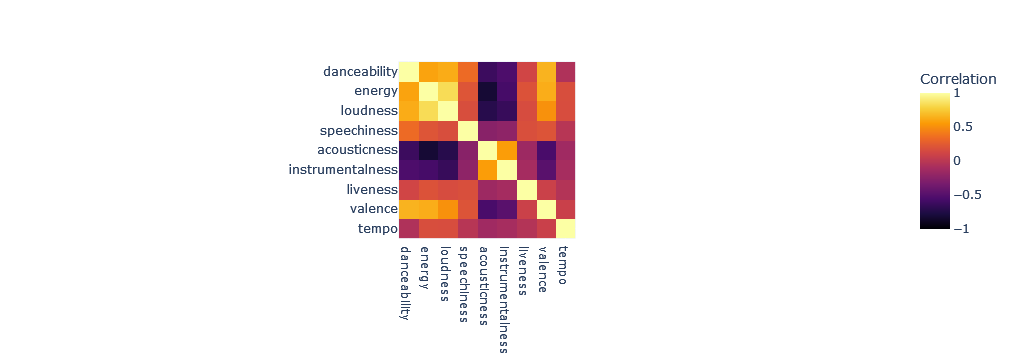

In [44]:
correlations_df = df[
    [
        "danceability",
        "energy",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
    ]
]
correlations = correlations_df.corr()


px.imshow(
    correlations,
    labels=dict(x="", y="", color="Correlation"),
    x=correlations_df.columns,
    y=correlations_df.columns,
    zmin=-1,
    zmax=1,
    color_continuous_scale="Inferno",
)

### Detalle Interesante 2: Correlación entre las Variables de Entrada y la Variable por Predecir 

In [45]:
labels = df.loc[:, ["genre"]]
labels

encoder = OneHotEncoder(sparse=False)
encoded_labels = encoder.fit_transform(labels)

encoded_labels_df = pd.DataFrame(encoded_labels, columns=encoder.get_feature_names())
encoded_labels_df

,x0_Clasica,x0_Disco,x0_Electronica,x0_Hiphop,x0_Jazz,x0_Pop,x0_Reggaeton,x0_Rock,x0_Rock latino
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
809,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
812,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


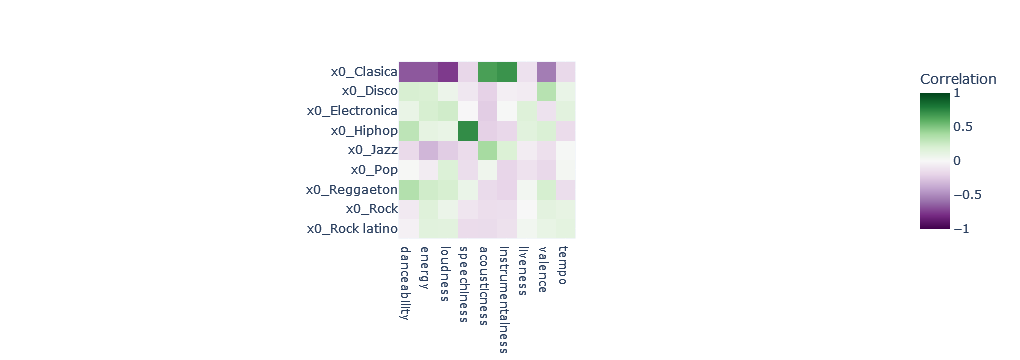

In [46]:
# juntamos correlations_df con encoded_labels_df

correlations_labels_df = pd.concat([correlations_df, encoded_labels_df], axis=1)

correlations_labels = correlations_labels_df.corr("pearson").iloc[9:, 0:9]

px.imshow(
    correlations_labels,
    labels=dict(x="", y="", color="Correlation"),
    x=correlations_labels.columns,
    y=correlations_labels.index,
    zmin=-1,
    zmax=1,
    color_continuous_scale="PRgn",
)

### Detalle Interesante 3: ¿Usamos Artista?

In [47]:
df["artist"].value_counts()

Daddy Yankee               6
Johann Sebastian Bach      6
John Coltrane              6
Miles Davis                5
The Rolling Stones         5
                          ..
Tantra                     1
Machine                    1
Grandmaster Flash          1
Evelyn "Champagne" King    1
Rachel Platten             1
Name: artist, Length: 506, dtype: int64

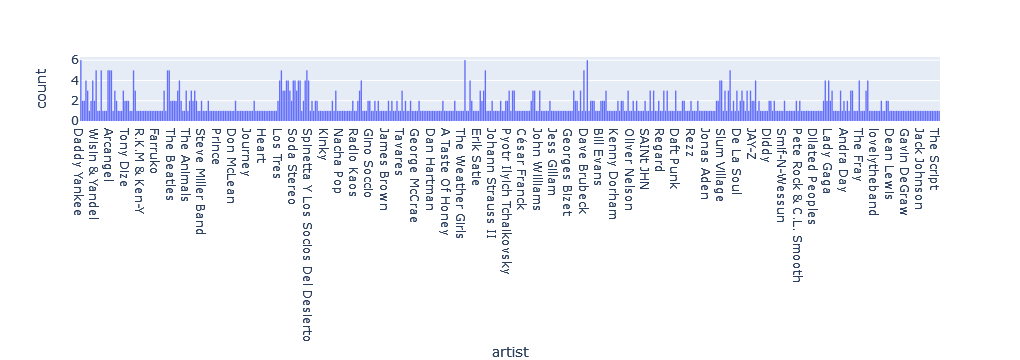

In [48]:
px.histogram(
    df,
    "artist",
)

In [49]:
artista_ohe = OneHotEncoder(sparse=False)
artista_encoded = artista_ohe.fit_transform(df[["artist"]])
artista_cols = artista_ohe.get_feature_names()


artista_df = pd.DataFrame(artista_encoded, columns=artista_cols)
artista_df

,x0_2Pac,x0_A Taste Of Honey,x0_A Tribe Called Quest,x0_AC/DC,x0_AWOLNATION,x0_Aaron Copland,x0_Adele,x0_Aerosmith,x0_Afu-Ra,x0_Alec Benjamin,...,x0_ZZ Top,x0_Zedd,x0_Zion,x0_Zion & Lennox,x0_Zoé,x0_Zurdok,x0_deadmau5,x0_lovelytheband,x0_Ñejo,x0_Ñejo & Dalmata
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
artista_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Columns: 506 entries, x0_2Pac to x0_Ñejo & Dalmata
dtypes: float64(506)
memory usage: 3.1 MB


**Esta transformación produce 519 dimensiones. Una locura...**

> **Pregunta:** ¿La cantidad de dimensiones influirá en la calidad de clasificación que logremos?

Imagínense ahora las correlaciones de cada una de estas viariables con respecto a la variable de salida.

### Maldición de la Dimensionalidad

La maldición de la dimensionalidad es el problema que consiste en que a medida que aumentan las dimensiones, los datos tienden a hacerse cada vez más *sparse*/escasos sobre las dimensiones en las cuales están representados. Una simple analogía para entender esto es que:

> *A medida que aumenta la cantidad de features, aumenta el volumen en donde se encuentran los datos, haciendo que estos se separen bastante entre ellos. *



<div align='center'>
    <img src='./resources/curse.png' width=600/>
</div>

<div align='center'>
    Fuente: <a href='https://www.researchgate.net/figure/The-effect-of-the-curse-of-dimensionality-when-projected-in-1-one-dimension-2-two_fig3_342638066'> A comprehensive survey of anomaly detection techniques for high dimensional big data en Research Gate.</a>
</div>


Esto implica que, para poder seguir distinguiendo correctamente los datos, se debe aumentar masivamente su cantidad a medida que se aumentan las dimensiones.

**¿En qué nos afecta esto?**

Induce comunmente a una reducción del rendimiento de los clasificadores/regresores.


Más en Wikipedia: [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).




## Optimizando la Clasificación


Entonces, hasta acá tenemos 3 problemas: 

1. Hay características que "aportan" más o menos la misma información.
2. Hay características que podrían no aportar información para poder clasificar correctamente.
3. Tenemos una gran cantidad de dimensiones, lo cual podría entorpecer la clasificación.


Por ende, sería ideal eliminar un par de dimensiones con el fin de mejorar la clasificación. 


Para comparar las mejoras, utilizaremos un **Baseline**, el cual no es más que es un modelo inicial al cual , a medida que vayamos generando mejores modelos, nos iremos comparando (para ver si mejoramos y cuanto). Durante toda esta clase, nuestro **baseline** (modelo que compararemos) será **Tree** entrenado con todas las features.


In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

preprocessing = ColumnTransformer(
    [
        (
            "Scale",
            MinMaxScaler(),
            [
                "danceability",
                "energy",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "valence",
                "liveness",
                "duration_ms",
                "loudness",
            ],
        ),
        (
            "One Hot Encoding",
            OneHotEncoder(sparse=False, handle_unknown="ignore"),
            [
                "key",
                "mode",
                "artist",
                "time_signature",
            ],
        ),
    ]
)

# Creamos nuestro baseline pipeline
baseline_pipe = Pipeline(
    steps=[("Preprocessing", preprocessing), ("Tree", DecisionTreeClassifier())]
)

### Holdout

In [52]:
from sklearn.model_selection import train_test_split

labels = df.loc[:, "genre"]
features = df.drop(columns=["genre"])

X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=50,
    shuffle=True,
    stratify=labels,
)

### Entrenamiento y Evaluación

In [53]:
from sklearn.metrics import f1_score


def train_and_evaluate(
    pipe, print_=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
):

    # notar que los datasets son parámetros por defecto.

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if print_:
        print("Matriz de confusión: \n")
        print(confusion_matrix(y_test, y_pred, labels=pipe.classes_))
        print("\nReporte de Clasificación: \n")
        print(
            classification_report(y_test, y_pred, target_names=pipe.classes_),
        )

    return f1_score(y_test, y_pred, average="weighted")


train_and_evaluate(baseline_pipe)

Matriz de confusión: 

[[20  0  0  0  0  0  0  0  0]
 [ 0  6  1  3  1  0  1  2  3]
 [ 0  1  4  1  0  3  0  1  2]
 [ 0  1  2 13  0  1  2  0  1]
 [ 1  1  0  0 10  1  0  0  1]
 [ 0  0  3  1  0  9  1  3  3]
 [ 0  1  1  1  0  2 13  1  1]
 [ 0  5  0  0  2  2  1  4  6]
 [ 0  2  0  0  1  2  2  4  9]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.95      1.00      0.98        20
       Disco       0.35      0.35      0.35        17
 Electronica       0.36      0.33      0.35        12
      Hiphop       0.68      0.65      0.67        20
        Jazz       0.71      0.71      0.71        14
         Pop       0.45      0.45      0.45        20
   Reggaeton       0.65      0.65      0.65        20
        Rock       0.27      0.20      0.23        20
 Rock latino       0.35      0.45      0.39        20

    accuracy                           0.54       163
   macro avg       0.53      0.53      0.53       163
weighted avg       0.54    

0.5363003498571357

> **Pregunta:❓** ¿Cómo sé que mi modelo es mejor que uno que clasifica al azar?


### Modelos Dummy

El [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier) es un clasificador que ignora todas las features de entrada y genera salidas aleatorias como respuesta a las predicciones.

Permite saber si los modelos que estamos implementando son mejores que clasificar al azar. Por lo general, es una de las primeros chequeos que hacemos ya que permite anticipadamente saber si estamos generando modelos que aprenden o no.

Para la regresión, existe [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor).

In [62]:
from sklearn.dummy import DummyClassifier

dummy_pipe = Pipeline(
    steps=[("Preprocessing", preprocessing), ("Tree", DummyClassifier())]
)

train_and_evaluate(dummy_pipe)

Matriz de confusión: 

[[1 1 1 2 4 4 2 4 1]
 [0 3 0 2 1 3 0 5 3]
 [1 1 0 3 2 2 0 0 3]
 [3 1 3 5 2 2 2 2 0]
 [1 1 5 0 0 0 3 4 0]
 [5 2 0 0 2 2 2 3 4]
 [2 3 4 3 0 1 3 3 1]
 [2 4 2 2 0 4 5 0 1]
 [2 1 0 3 4 1 4 3 2]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.06      0.05      0.05        20
       Disco       0.18      0.18      0.18        17
 Electronica       0.00      0.00      0.00        12
      Hiphop       0.25      0.25      0.25        20
        Jazz       0.00      0.00      0.00        14
         Pop       0.11      0.10      0.10        20
   Reggaeton       0.14      0.15      0.15        20
        Rock       0.00      0.00      0.00        20
 Rock latino       0.13      0.10      0.11        20

    accuracy                           0.10       163
   macro avg       0.10      0.09      0.09       163
weighted avg       0.10      0.10      0.10       163



/home/pablo/miniconda3/lib/python3.9/site-packages/sklearn/dummy.py:131: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



0.10027550114337484


-------------

## Selección de atributos


- Técnicas para **buscar el mejor subconjunto de atributos** para un problema de clasificación/regresión.

- Es supervisada, es decir, requieren un problema con datos etiquetados.

### Scheme independent o Método de Filtro .


Compara los atributos solo con las etiquetas a través de test estadísticos simples e ignora la relación entre atributos.


- Varias métricas para clasificación: Anova (`f_classif`), Mutual information (`mutual_info_classif`), Chi squared (`chi2`), ...

- Para regresión, se usan otro tipo de métricas.

- Referencia: [Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).



Métricas: 

- `f_classif`: F-test estimate the degree of linear dependency between two random variables. 
    
- `mutual_info_classif`: Mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

- `chi2`: This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.


Estrategias: 

- `SelectKBest` selecciona las features con los mejores valores. Hay que especificar el número de features que seleccionaremos.

- `SelectPercentile` selecciona el percentil con mejores valores. Hay que especificar con cuanto percentil quedarse.

**`Anova`**

    Computes ANOVA F-value for each sample. F-value estimate the degree of linear dependency between two random variables.
        
Más información: https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w

In [54]:
from sklearn.feature_selection import (
    SelectKBest,
    SelectPercentile,
    f_classif,
    mutual_info_classif,
)

# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=70)),
        ("Tree", DecisionTreeClassifier()),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[20  0  0  0  0  0  0  0  0]
 [ 0  7  1  2  1  0  1  2  3]
 [ 0  3  3  1  1  1  0  1  2]
 [ 0  0  2 13  0  1  3  0  1]
 [ 3  1  0  0  9  1  0  0  0]
 [ 0  0  2  0  1 10  1  4  2]
 [ 0  0  2  1  0  2 13  1  1]
 [ 1  6  0  0  2  3  1  4  3]
 [ 0  2  1  0  0  2  2  4  9]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.83      1.00      0.91        20
       Disco       0.37      0.41      0.39        17
 Electronica       0.27      0.25      0.26        12
      Hiphop       0.76      0.65      0.70        20
        Jazz       0.64      0.64      0.64        14
         Pop       0.50      0.50      0.50        20
   Reggaeton       0.62      0.65      0.63        20
        Rock       0.25      0.20      0.22        20
 Rock latino       0.43      0.45      0.44        20

    accuracy                           0.54       163
   macro avg       0.52      0.53      0.52       163
weighted avg       0.53    

0.5330385104796492

In [55]:
# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier()),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[20  0  0  0  0  0  0  0  0]
 [ 0  6  1  2  1  0  1  2  4]
 [ 0  3  4  0  0  1  0  3  1]
 [ 0  1  0 12  0  0  3  1  3]
 [ 3  1  0  0  7  2  0  0  1]
 [ 0  0  2  0  1 10  1  2  4]
 [ 0  0  3  1  0  2 13  1  0]
 [ 0  7  0  0  2  2  1  4  4]
 [ 1  2  0  0  1  2  2  5  7]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.83      1.00      0.91        20
       Disco       0.30      0.35      0.32        17
 Electronica       0.40      0.33      0.36        12
      Hiphop       0.80      0.60      0.69        20
        Jazz       0.58      0.50      0.54        14
         Pop       0.53      0.50      0.51        20
   Reggaeton       0.62      0.65      0.63        20
        Rock       0.22      0.20      0.21        20
 Rock latino       0.29      0.35      0.32        20

    accuracy                           0.51       163
   macro avg       0.51      0.50      0.50       163
weighted avg       0.51    

0.5081301538455196

In [56]:
# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(mutual_info_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier(random_state=20)),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[19  0  0  0  1  0  0  0  0]
 [ 0  7  1  2  1  0  1  2  3]
 [ 0  2  5  1  0  2  0  1  1]
 [ 0  0  2 13  0  1  3  0  1]
 [ 2  1  0  0  8  2  0  0  1]
 [ 0  0  2  0  0 10  1  3  4]
 [ 0  2  1  2  0  2 13  0  0]
 [ 0  5  0  0  3  2  1  4  5]
 [ 0  3  0  0  1  1  2  6  7]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.90      0.95      0.93        20
       Disco       0.35      0.41      0.38        17
 Electronica       0.45      0.42      0.43        12
      Hiphop       0.72      0.65      0.68        20
        Jazz       0.57      0.57      0.57        14
         Pop       0.50      0.50      0.50        20
   Reggaeton       0.62      0.65      0.63        20
        Rock       0.25      0.20      0.22        20
 Rock latino       0.32      0.35      0.33        20

    accuracy                           0.53       163
   macro avg       0.52      0.52      0.52       163
weighted avg       0.53    

0.525550046437602

> **Pregunta:** ¿Cómo elegir el mejor percentil de features por conservar?

In [57]:
selection_pipeline

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('Scale', MinMaxScaler(),
                                                  ['danceability', 'energy',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'valence', 'liveness',
                                                   'duration_ms', 'loudness']),
                                                 ('One Hot Encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['key', 'mode', 'artist',
                                                   'time_signature'])])),
                ('Selection',
                 SelectPercentile(perc

In [58]:
selection_pipeline.steps[1][1]

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_classif at 0x7fdb501770d0>)

In [ ]:
selection_pipeline.steps[1][1].percentile

In [ ]:
f1 = []
for i in range(5, 101, 2):
    selection_pipeline.steps[1][1].percentile = i
    f1.append([i, train_and_evaluate(selection_pipeline, print_=False)])
f1 = np.array(f1)

px.line(
    x=f1[:, 0],
    y=f1[:, 1],
    title="F1 según cantidad de Features Conservadas",
)

## Grid Search


Si bien el ciclo anterior nos permitió encontrar el mejor valor para el percentil de la selección de atributos, es bastante trabajo implementarlo, pensando más aún que comunmente se quieren optimizar varias partes del pipeline y no solo un paso en específico.

En el caso anterior, un ejemplo de esto podría ser variar el percentil como la métrica usada, teniendo una malla de búsqueda del estilo:

| `f_classif` | `mutual_info_classif` |
|---|---|
| 10 | 10 |
| 20 | 20 |
| 30 | 30 |
| 40 | 40 |
| 50 | 50 |
| 60 | 60 |
| 70 | 70 |
| 80 | 80 |
| 90 | 90 |
| 100 | 100 |


Por esto, la idea es tener un mecanismo para el cual podamos pasarle una lista de hiperparámetros, que este lo pruebe todos y que retorne el mejor modelo. 
Este mecanismo en `scikit-learn` es conocido como Búsqueda de grilla o `Grid-search`.





### Encontrar los Parámetros Disponibles para Modificar

En general, cualquier clase de scikit-learn implementa la función `get_params`, la cual muestra los parámetros disponibles para probar y modificar.


In [ ]:
DecisionTreeClassifier().get_params()

Para el caso de una `Pipeline`, muestra las `steps` de la pipeline más los parámetros de cada una de las steps. 
Noten que los parámetros de cada `step` siguen la notación: `{nombre_step}__{parámetro_step}`

Ejemplo: Número de percentiles que escogeremos - `selection__percentile`



In [ ]:
selection_pipeline.get_params()

La idea es definir un grilla de hiperparámetros para que GridSearch los explore y elija el mejor.

In [ ]:
list(range(5, 101, 5))

In [ ]:
param_grid = [{"Selection__percentile": range(5, 101, 5)}]
param_grid

In [ ]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(selection_pipeline, param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

Los resultados de la exploración de grilla los pueden visualizar así: 

In [ ]:
pd.DataFrame(gs.cv_results_)

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_estimator_.steps[1][1]

Aquí vemos los scores de cada feature con respecto a la clase de salida.

In [ ]:
gs.best_estimator_.steps[1][1].scores_

#### Ejemplo de Uso para Predicción de GridSearch

In [ ]:
# sacamos el vector de los atributos desde las features
gs.predict(X_test)

> **Pregunta**: Tengo desbalance de clases... ¿Y si quiero evaluar por F1 y no por Accuracy?


Cambiar el parámetro scoring por alguna métrica: 

<center>
<img src='./resources/metricas_gridsearch.png' width=800/>
<center/> 
   
<center>
Fuente: <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter'>Métricas en scikit-learn. </a>
<center/>

In [ ]:
gs = GridSearchCV(selection_pipeline, param_grid, n_jobs=-1, scoring="f1_micro")
gs.fit(features, labels.values.ravel())

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

> **Pregunta**: ¿Y si ahora quiero usar otra métrica univariada para seleccionar atributos?

Por ejemplo, [`Mutual information`](https://en.wikipedia.org/wiki/Mutual_information)

    **Mutual information (MI)** [1] between two random variables is a non-negative value, which quantifies the "amount of information" obtained about one random variable through observing the other random variable.
    
    It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.


Vamos nuevamente a buscar el nombre del atributo que queremos modificar y ejecutamos nuevamente grid-search.

In [ ]:
selection_pipeline.get_params()

In [ ]:
from sklearn.feature_selection import f_classif, mutual_info_classif

param_grid = [
    {
        "Selection__percentile": range(5, 101, 5),
        "Selection__score_func": [f_classif, mutual_info_classif],
    }
]

In [ ]:
gs = GridSearchCV(selection_pipeline, param_grid, n_jobs=-1)
train_and_evaluate(gs)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

### `Grid Search` y `CV` (Cross Validated)

`Grid Search` recibe como parámetro todo el dataset y (a diferencia de la función que definimos en el baseline) ejecuta un cross validation sobre todos los parámetros.

Una vez terminada la búsqueda de los mejores parámetros sobre cada fold, **por defecto**, entrena con todos los datos utilizados. **ESTO PUEDE CAUSAR DATA LEAKAGES**. Por eso, se debe entrenar con `X_train` y `y_train` y no con todo el dataset.


<center>
    <img src='./resources/kfold.png' width=400/>
</center>

In [ ]:
pd.DataFrame(gs.cv_results_)

> **Pregunta**: ¿Podemos entonces también cambiar el clasificador y probar varios tipos?
    
Efectivamente, pero escojimos `DecisionTreeClassifier` como baseline para evaluar los métodos de selección. En los labs y proyecto tendrán que variar también el clasificador.

> **Observación**: Uno de los grandes problemas de GridSearch es que calcula muchas veces valores que ya habían sido calculados con anterioridad y que se supone no cambiarían, como por ejemplo los f-score por fold. 

En esta issue se presenta el problema y una propuesta de solución.

https://github.com/scikit-learn/scikit-learn/issues/10755

-------------------------

## Reducción de la dimensionalidad

Técnicas que reducen el número de características de forma no supervisadas.

- Eliminan ruido.
- Mejoran el rendimiento de los clasificadores.
- Pueden proyectar datos en dos/tres dimensiones.

**Problemas** con algoritmos de reducción de dimensionalidad: 


- Las dimensiones ya no son intepretables.



### Principal Component Analysis


Reduce dimensiones de nuestro dataset tratando de no perder mucha información.

Objetivo. Encontrar direcciónes tales que al proyectar nuestros datos, la varianza de los puntos proyectados se maximize.

<center>
<img src='./resources/pca.jpg' width=600/>
    </center>
    
<center>
Fuente: <a href='https://devopedia.org/principal-component-analysis'>https://devopedia.org/principal-component-analysis</a>

</center>

In [ ]:
fig = px.scatter(df, x="energy", y="loudness", color="genre")

fig.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
components = pca.fit_transform(df[["energy", "loudness"]])
labels_ = {
    ["x", "y"][i]: f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter(
    x=-components[:, 0], y=-components[:, 0], color=df["genre"], labels=labels_
)


fig.show()

### Varianza explicada

**¿Cuánta información mantenemos después de ejecutar PCA?**

Cada componente explica una cierta cantidad de varianza de los datos.
Esto esta determinado por los autovalores $\lambda$

Los componentes con mayor varianza incuirán mayor información.


In [ ]:
n_components = 3

pca = PCA(n_components=n_components)
components = pca.fit_transform(preprocessing.fit_transform(features))

total_var = pca.explained_variance_ratio_.sum() * 100

labels_ = [
    f"PC {i+1} = {var:.1f}%"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
]

fig = px.scatter_matrix(
    components,
    color=df["genre"],
    dimensions=range(n_components),
    labels=labels_,
    title=f"Varianza Explicada Total: {total_var:.2f}%.<br>Varianza por Componente: {labels_}",
    height=800,
)
fig.update_traces(diagonal_visible=False)

fig.show()

### ¿Cómo encontrar la mejor cantidad de dimensiones?

Vamos viendo cuanta varianza acumula cada componente.

En algún punto, la varianza marginal que acumula el siguiente es mucho mas baja que la anterior. 
Ese es el punto indicado en donde cortar.


Esto lo podemos ver en el siguiente gráfico:


In [ ]:
pca = PCA()
pca.fit(preprocessing.fit_transform(features))
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Número de componentes", "y": "Varianza explicada"},
)

Mas o menos en los 8 componentes principales ya se explican mas del 90% de la varianza del dataset.

In [ ]:
# Creamos nuestro baseline pipeline

pca_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Reduccion", PCA()),
        ("Tree", DecisionTreeClassifier()),
    ]
)

In [ ]:
pca_pipeline.get_params()

In [ ]:
param_grid = [{"Reduccion__n_components": [10, 20, 30, 40, 50, 100, 200]}]
gs_pca = GridSearchCV(pca_pipeline, param_grid=param_grid)

train_and_evaluate(gs_pca)

In [ ]:
gs_pca.best_estimator_

### Mejoras a GridSearch

#### `HalvingGridSearchCV`


![](./resources/halvinggscv.png)

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
from sklearn.feature_selection import f_classif, mutual_info_classif

selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier()),
    ]
)

param_grid = [
    {
        "Selection__percentile": range(5, 101, 10),
        "Selection__score_func": [f_classif, mutual_info_classif],
    }
]

hgs = HalvingGridSearchCV(selection_pipeline, param_grid)

train_and_evaluate(hgs)

### Proyectos Relacionados

https://scikit-learn.org/stable/related_projects.html

- `scikit-optimize`: A library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization, and includes a replacement for GridSearchCV or RandomizedSearchCV to do cross-validated parameter search using any of these strategies.

- `sklearn-deap` Use evolutionary algorithms instead of gridsearch in scikit-learn.
